In [1]:
%pip install geopandas
%pip install pyrosm
%pip install gtfs_kit
%pip install h3
%pip install pyproj
%pip install keplergl
%pip install matplotlib
%pip install esy-osmfilter
%pip install rasterio
%pip install joypy
%pip install sklearn
%pip install pyproj

Note: you may need to restart the kernel to use updated packages.
  Using cached pyrosm-0.6.1.tar.gz (2.1 MB)
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /home/jacdals97/anaconda3/envs/transit/bin/python /tmp/pip-standalone-pip-7u_fmc38/__env_pip__.zip/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-wqwsx2jx/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel Cython cykhash pyrobuf
       cwd: None
  Complete output (193 lines):
    Using cached setuptools-62.2.0-py3-none-any.whl (1.1 MB)
    Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
    Using cached Cython-0.29.28-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
    Using cached cykhash-2.0.0.tar.gz (43 kB)
    Installing build dependencies: started
    Installing build dependencies: finished with status 'done'
    Getting requirements t

# Data aquisition and preprocessing for new danish Transit Acessibility score

In this notebook we go through the different steps taken in order to produce the raw data needed for generating the transit accesibility map for Denmark as visualized here https://potatotvnet.github.io/transit/

The project utilizes data from a variety of different sources. These are listed here for completeness
* We downloaded the entire schedule of the public transit in Denmark for a typical week in march 2022 (20/03/22 to 26/03/22) in the standard GTFS data format using the Rejseplanen API https://help.rejseplanen.dk/hc/da/articles/214174465-Rejseplanens-API (danish only). This data range does not include any special holidays.
* We used OpenStreetMap data for the entirety of Denmark as collected by Geofabrik.de (https://download.geofabrik.de/europe/denmark.html). The data is used for generating the walkable paths that connect people to public transit.
* We downloaded the Global Human Settlement Layers (GHSL) covering all of Denmark (https://ghsl.jrc.ec.europa.eu/download.php?ds=smod). The layers are satelite images and were used to determine the rural and urban areas of Denmark. 

In terms of Python libraries that work on geospatial data we highligt the following tools
* H3 was used to convert points, stops and paths from the WGS 84 coordinate reference system to a spatial index of hexagons to decrease the amount of space and computation needed in order to work with this much data
* GTFS kit provides powerful functionality to convert data from the GTFS format to more Python standard formats like the geodataframe from geopandas.
* Geopandas/pandas standard tools for data wrangling
* esy-osmfilter Loading large pbf files (such as the danish OSM data) using libraries such as Pyrosm which converts the data to a GeoDataFrame is very memory intensive and should be avoided when working on a standard laptop. We use esy-osmfilter to filter the OSM data to include only what we want and save it to a geojson which we can work with in python.
* Rasterio provides functionality to work with raster images such as satelite images. We use it for reading, rendering and projecting the GHSL data.

In [1]:
import sys
from pathlib import Path
import json
import h3
import pandas as pd
import numpy as np
import geopandas as gp
import shapely as shp
import gtfs_kit as gk
from shapely.geometry import mapping, shape

## Read GTFS feeds
Initially we wanted to see if our methods would scale to include more than one transit ressource (ie multiple GTFS files) however we later found this to be out of scope for the project

Specify the paths to the zip files here. 

In [3]:
H3_RES = 11
# read GTFS data from multiple GTFS files is possible
paths = ["../resources/rejseplanen.zip"]
feeds = []
for path in paths:
    feeds.append(gk.read_feed(path, dist_units='km'))

dates = ['20220320', '20220321', '20220322', '20220323', '20220324', '20220325', '20220326']

Map all stops to their corresponding H3 cell

In [4]:
# map all stops to h3 for each feed (ie each GTFS file)
stop_h3_maps = []
for feed in feeds:
    feed.stops['h3'] = feed.stops.apply(lambda row: h3.geo_to_h3(row['stop_lat'],row['stop_lon'],H3_RES), axis=1)
    stop_h3_maps.append(pd.Series(feed.stops.h3.values,index=feed.stops.stop_id).to_dict())


Write back data in geojson

In [5]:
%%capture --no-display
geojson = feed.routes_to_geojson(include_stops=True)
with open("data/geojson.json", "w") as outfile:
    json.dump(geojson, outfile)

## Work covering the danish transit data

Take the danish transit feed and turn the routes into a GeoDataFrame

In [6]:
%%capture --no-display
routes = gk.routes.geometrize_routes(feeds[0])
routes.head()


,route_id,geometry,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color,route_desc
0,10001_3,"MULTILINESTRING ((12.28094 55.38463, 12.28139 ...",221,109,NaN,3,NaN,NaN,NaN
1,10033_3,"LINESTRING (11.32831 55.38977, 11.32859 55.389...",221,903,NaN,3,NaN,NaN,NaN
2,10163_3,"MULTILINESTRING ((12.22725 55.35119, 12.22729 ...",221,253,NaN,3,NaN,NaN,NaN
3,10164_3,"MULTILINESTRING ((12.22736 55.35099, 12.22743 ...",221,99N,NaN,3,NaN,NaN,NaN
4,10214_3,"LINESTRING (11.87714 54.76683, 11.87711 54.766...",221,741,NaN,3,NaN,NaN,NaN


Transform geometries into arrays containing geometry points and write data

In [7]:
def transform_geo(geo):
    if type(geo) == shp.geometry.LineString:
        return [[g[0], g[1]] for g in list(geo.coords)]
    else:
        return [[g[0], g[1]] for g in list(geo.geoms[0].coords)]

routes_filtered = routes
routes_new = []

for idx, route in routes_filtered.iterrows():
    name = route["route_short_name"]
    category = route["route_type"]
    geo = route["geometry"]
    if type(geo) == shp.geometry.LineString:
        routes_new.append([name, category, [[g[0], g[1]] for g in list(geo.coords)]])
    else:
        for ge in geo.geoms:
            routes_new.append([name, category, [[g[0], g[1]] for g in list(ge.coords)]])

routes_df = pd.DataFrame(routes_new, columns= ['name', 'category', 'geo'])

routes_df.head()

,name,category,geo
0,109,3,"[[12.280937, 55.384628], [12.281387, 55.384157..."
1,109,3,"[[12.187489, 55.456978], [12.187485, 55.456924..."
2,109,3,"[[12.187489, 55.456978], [12.187485, 55.456924..."
3,903,3,"[[11.328311, 55.389772], [11.328595, 55.389757..."
4,253,3,"[[12.227247, 55.351191], [12.227285, 55.351262..."


In [8]:
routes_df.to_csv("data/routes.csv")

### Calculate Frequencies
We compute a time series for every stop in our one week interval for every 1 hour

In [9]:
# compute time series for the Rejseplan schedule this includes the frequency of departures at every stop, every hour for a week.
ts = []
for feed in feeds:
    a = feed.compute_stop_time_series(dates=dates, freq='60Min').transpose().reset_index(level=1)
    ts.append(a)

Implement a function that takes a list of lists and adds elements

In [10]:
def add_lists(lists):
    res = np.array([0]*len(lists[0]))
    for i in range(len(lists)):
        l = np.array(lists[i])
        l = np.nan_to_num(l)
        # print(f"adding res with {np.shape(res)} and list with {np.shape(l)}")
        res = np.add(res, l)
        # print(f"resulting shape: {np.shape(res)}")
    return res

Here we create our initial h3 map which maps the frequency of departures as a sum of all departures during an hour within our specified hexagons. This means the value of a hexagon can be the sum of departures from multiple stops. We furthermore create a queue of stops. 

In [11]:
result_df = pd.DataFrame()
for idx, feed in enumerate(feeds):
    tts = ts[idx]
    result_df['stop_id'] = tts['stop_id'].values.tolist()
    result_df['h3'] = result_df.apply(lambda row: stop_h3_maps[idx][row['stop_id']], axis=1)
    result_df['frequency'] = tts.iloc[:,1:].values.tolist()

# unique_h3s = set(stop_h3_maps[idx].values())
unique_h3s = [item for sublist in stop_h3_maps for item in sublist.values()]
h3_map = {}
h3_queue = []
for index in unique_h3s:
    h3_queue.append(index)
    res = result_df.loc[result_df['h3'] == index]
    if res.shape[0] > 1:
        res = add_lists(res['frequency'].values.tolist())
        h3_map[index] = res.tolist()
    elif res['frequency'].any():
        h3_map[index] = np.nan_to_num(res['frequency'].values[0]).tolist()
    

### Identifying stop types

For each stop we identify which type of stop it is as specified in the GTFS specifications. We similarly find that custom stop types have been added and map these to a relevant stop type. As thus we encode stop types as follows
* busses (stop code 3), Midttrafik busses (stop code 700 and 715) $\to$ 0
* trams and ferries (stop code 0 and 4) $\to$ 1
* S-train and metro (stop code 109 and 1) $\to$ 2
* Trains (stop code 1) $\to$ 3 

In [ ]:
stop_type_map = {}


for _, route in feeds[0].routes.iterrows():
    route_type = route['route_type']
    # s tog becomes metro
    if route_type == 109 or route_type == 1:
        route_type = 2
    # busses in midtrafik
    elif route_type == 700 or route_type == 715 or route_type == 3:
        route_type = 0
    elif route_type == 2:
        route_type = 3
    else:
        route_type = 1

    stops = gk.get_stops(feeds[0], route_ids=[route['route_id']])['stop_id']
    for stop in stops:
        h3_index = stop_h3_maps[0][stop]
        try:
            current = stop_type_map[h3_index]
            if route_type > current:
                stop_type_map[h3_index] = route_type
        except KeyError:
            stop_type_map[h3_index] = route_type

### Read in data from osm_convert.py

The script filters through the danish OSM data keeping only way elements containing the `highway` key and any of the following values
* "footway"
* "path"
* "pedestrian"
* "cycleway"
* "residential"
* "unclassified"
* "tertiary"
* "secondary"
We chose the above keys because of the scope of our project which is determined to cover transit accesibility for all of Denmark. As such, while tertiary and secondary roads might not be accesible by foot because there is no pavement we include them to accomodate the fact that for rural areas these types of stops do exist. For definitions see https://wiki.openstreetmap.org/wiki/Key:highway  
Finally it removes the key value pair `foot:no` see https://wiki.openstreetmap.org/wiki/Key:foot 

The `osm_convert.py` script is too memory intensive to execute through a jupyter notebook, you will have to run this separately

In [ ]:

with open('data/dkall.geojson') as json_file:
    data = json.load(json_file)

# Switching coordinates
for geo in data['features']:
    geo['geometry']['coordinates'] =  [[y,x] for x,y in geo['geometry']['coordinates']]


# Methods to convert OSM ways to H3 hexagons

First we define a function that can project different types of geometries to and from WGS 84 and the UTM zone 32N. We do this to work with buffering in metres. If we buffer using WGS 84 we are more likely to produce distortions when buffering an object.

In [ ]:
from pyproj import Transformer, CRS


crs_4326 = CRS.from_epsg(4326)
crs_25831 = CRS.from_epsg(25832)

to_dk = Transformer.from_crs(crs_4326, crs_25831)
to_WGS = Transformer.from_crs(crs_25831, crs_4326)


def CRS_transform(shp, inv=False):
    geoInterface = shp.__geo_interface__

    shpType = geoInterface['type']
    coords = geoInterface['coordinates']
    if shpType == 'Polygon':
        if inv:
            newCoord = [[to_WGS.transform(*point) for point in linring] for linring in coords]
        else:
            newCoord = [[to_dk.transform(*point) for point in linring] for linring in coords]
    elif shpType == 'LineString':
        if inv:
            newCoord = [to_WGS.transform(*point) for point in coords]
        else:
            newCoord = [to_dk.transform(*point) for point in coords]
    elif shpType == 'MultiPolygon':
        if inv:
            newCoord = [[[to_WGS.transform(*point) for point in linring] for linring in poly] for poly in coords]
        else:
            newCoord = [[[to_dk.transform(*point) for point in linring] for linring in poly] for poly in coords]

    return shape({'type': shpType, 'coordinates': tuple(newCoord)})

### Polyfill method

The first method goes through every object and projects the coordinates to the proper CRS with metric units. We then buffer the objects using a 10 meter buffer and reproject back to WGS 84. Then we invoke the H3 polyfill function which transforms a polygon into h3 indices. 

In [ ]:
from shapely.geometry import mapping, shape


h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    tmp = CRS_transform(tmp)
    tmp = tmp.buffer(10)
    tmp = CRS_transform(tmp, inv = True)

    if mapping(tmp)['type'] == 'Polygon':
        h3_set.update(h3.polyfill(mapping(tmp), 11, geo_json_conformant=False))
    elif mapping(tmp)['type'] == 'MultiPolygon':
        polygons = list(tmp)
        for poly in polygons:
            h3_set.update(h3.polyfill(mapping(poly), 11, geo_json_conformant=False))
    else:
        break
    

### Line interpolation method

For this method we reproject the gemetries from the WGS 84 CRS to the UTM zone 32N with metric units. We then create points along the way objects for every 10 meters using shapely interpolation. The point coordinates can then be used to make h3 indices.

In [ ]:
from shapely.geometry import mapping, shape, LineString
import numpy as np


h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    tmp = CRS_transform(tmp)
    distances = np.arange(0, tmp.length, 10)
    points = [tmp.interpolate(distance) for distance in distances] 
    if len(points) == 1:
        continue
    tmp = LineString(points)
    tmp = CRS_transform(tmp, inv = True)
    h3s = {h3.geo_to_h3(lat, lon, 11) for (lat, lon) in mapping(tmp)['coordinates']}
    h3_set.update(h3s)
    

### H3 line method

The method we ended up using was to use the h3 line function which returns the indices of the hexagons forming a line between two points. We could therefore iterate over the points in every way object from OSM data and generate our walkable hexagons that way.

In [ ]:

h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    if len(mapping(tmp)['coordinates']) == 1:
        h3_set.add(h3.geo_to_h3(*mapping(tmp)['coordinates'], resolution = 11))
    for i in range(len(mapping(tmp)['coordinates']) - 1):
        h3s = h3.h3_line( h3.geo_to_h3(*mapping(tmp)['coordinates'][i], resolution = 11) , h3.geo_to_h3(*mapping(tmp)['coordinates'][i+1], resolution = 11) )
        h3_set.update(h3s)

We write this data

In [ ]:
walk = pd.DataFrame(list(h3_set), columns=['h3'])
walk.to_csv("data/line_paths_11.csv")

### H3 edges method

This method is similar to the h3 line function described above but only returns the unidirectional edges of the hexagons making up our paths. 

In [ ]:
h3_set = set()
for geo in data['features']:
    tmp = shape(geo['geometry'])
    if len(mapping(tmp)['coordinates']) == 1:
        continue
        h3_set.add(h3.geo_to_h3(*mapping(tmp)['coordinates'], resolution = 11))
    for i in range(len(mapping(tmp)['coordinates']) - 1):
        h3s = h3.h3_line( h3.geo_to_h3(*mapping(tmp)['coordinates'][i], resolution = 11) , h3.geo_to_h3(*mapping(tmp)['coordinates'][i+1], resolution = 11) )
        h3_edges = [h3.get_h3_unidirectional_edge(h3s[i], h3s[i+1]) for i in range(len(h3s) -1)]
        h3_set.update(h3_edges)


In [ ]:
#walk = pd.DataFrame(list(h3_set), columns=['h3'])
#walk.to_csv("data/edges_paths_11.csv")

### Add walking network

In [ ]:
walk = pd.read_csv("data/line_paths_11.csv")

We check whether the walkable h3 indices are part of the h3 stop indices and assign them an array of zero frequencies if they are not. 

In [ ]:
walk_map = {}

for w in walk['h3']:
    try:
        h3_map[w]
        continue
    except KeyError:
        walk_map[w] = [0]*(24*7)

### Adding the walking network to the stops data

Starting from our stops we go through neighboring hexagons and check whether they are part of the walkable h3 indices. If so, we add them and their frequencies to our h3 map data we then add them to queue and keep track of which hexagons we have visited. By doing this we add our walking network as well as dropping indices that are not connected to a stop.

In [ ]:
visited_map = {}

while h3_queue:
    current = h3_queue.pop()
    visited_map[current] = True
    for hexagon in h3.k_ring(current, 1):
        # add hexagon to the network
        try:
            h3_map[hexagon] = walk_map[hexagon]
        except KeyError:
            continue
        # add unvisited hexagons to the queue
        try:
            visited_map[hexagon]
            continue
        except KeyError:
            h3_queue.append(hexagon)



It might be wise to do some garbage collection by now

In [ ]:
import gc
del walk_map
del walk
del h3_set
del data 
del result_df
del stops
del feeds
del a
del ts
gc.collect()

# Reading EU urbanization data

We work with raster image data and utilize the rasterio library to handle the layered nature of the data.

In [ ]:
import rasterio
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import colors
from rasterio.plot import show
import rasterio.warp
from rasterio.crs import CRS

Here is the data visualized. Every pixel value corresponds to a label of a $1km^2$ square. The data is documented here https://ghsl.jrc.ec.europa.eu/documents/GHSL_Data_Package_2019.pdf pages 17-27

<AxesSubplot:>

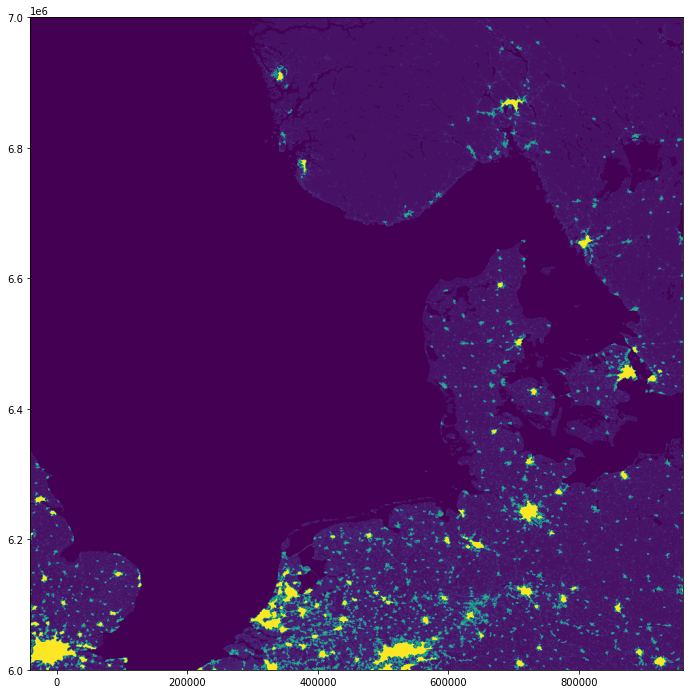

In [ ]:
fp = r'GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_18_2.tif'
img = rasterio.open(fp)
fig, ax = plt.subplots(1, figsize=(12, 12))
show(img, ax=ax)

The above picture clearly omits Bornholm. The reason is that the data is downloaded on a per grid level. We therefore need to include the grid containing Bornholm.

In the following code we go through both grids containing the danish data. We construct arrays of the the coordinate values of the image pixels, as specified by the CRS of the data which is "World_Mollweide". We transform the coordinates to WGS 84, create the h3 indices at resolution 7 otherwise our map will be incomplete. We specify urban areas as pixels with values 21, 22, 23 or 30 and values 11, 12, 13 as rural areas as specified in the data documentation. Pixels with value 10 are water pixels and they are removed. Finally, we assign hexagons at resolution 11 the corresponding urban-rural label depending on their parent h3 index. If a parent h3 index is from a water pixel we assign it as a rural hexagon.  

In [ ]:
urban_map = dict()
fps = ['GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_18_2.tif','GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0_19_2.tif']
for fp in fps:
    with rasterio.open(fp) as src:
        band1 = src.read(1)
        print('Band1 has shape', band1.shape)
        height = band1.shape[0]
        width = band1.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons= np.array(xs)
        lats = np.array(ys)
        print('lons shape', lons.shape)
        xs_t, ys_t = rasterio.warp.transform(
            CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],\
                AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],\
                PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
            CRS.from_epsg(4326),
            xs = lons.flatten(),
            ys = lats.flatten()
        )
        for x,y, val in zip(xs_t, ys_t, band1.flatten()):
            if val == 10:
                continue
            elif val in [21, 22, 23, 30]: #urban pixel values
                urban_map[h3.geo_to_h3(y,x, resolution=7)] = 1
            else:
                urban_map[h3.geo_to_h3(y,x, resolution=7)] = 0


for hexagon in h3_map.keys():
    par = h3.h3_to_parent(hexagon, 7)
    try: # some parents are water
        h3_map[hexagon] = (h3_map[hexagon], urban_map[par]) 
    except:
        h3_map[hexagon] = (h3_map[hexagon], 0)

        

Band1 has shape (1000, 1000)
lons shape (1000, 1000)
Band1 has shape (1000, 1000)
lons shape (1000, 1000)


### Export Data

In [ ]:
with open("data/h3_map.json", "w") as outfile:
    json.dump(h3_map, outfile)
with open("data/stop_type_map.json", "w") as outfile:
    json.dump(stop_type_map, outfile)
with open("data/stop_h3_map.json", "w") as outfile:
    json.dump(stop_h3_maps[0], outfile)

Read in data if neccesary

In [2]:
with open('data/h3_map.json') as json_file:
    h3_map = json.load(json_file)
with open('data/stop_type_map.json') as json_file:
    stop_type_map = json.load(json_file)
#with open('data/stop_h3_map.json') as json_file:
#    stop_h3_map = json.load(json_file)

## Final dataset creation

Here we put together the final version of our raw dataset containing h3 indices at resolution 11 for computation, at resolution 10 for aggregation and visualization, and at resolution 4 for fast rendering in visualization. The every index at resolution 11 has an array of length 24*7 containing the frequency of departures at every hour of the week at stops, while for paths all values are 0. The indices also have information about the whether it is urban or rural and what type of stop the index is, as specified by our stop map. For non-stops this value is -1.

In [6]:
new = pd.DataFrame()
new['h3'] = h3_map.keys()
new['h3_group'] = new.apply(lambda row: h3.h3_to_parent(h = row['h3'], res=4), axis=1)
new['h3_group_agg'] = new.apply(lambda row: h3.h3_to_parent(h = row['h3'], res=H3_RES-1), axis=1)
new['freq'] = [x[0] for x in h3_map.values()]
new['urban'] = [x[1] for x in h3_map.values()]
new['type'] = new.apply(lambda row: -1 if sum(row['freq']) == 0 else stop_type_map[row['h3']], axis=1)
new.head()

,h3,h3_group,h3_group_agg,freq,urban,type
0,8b1f04d56803fff,841f04dffffffff,8a1f04d56807fff,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",0,0
1,8b1f23798753fff,841f237ffffffff,8a1f23798757fff,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, ...",0,3
2,8b1f23780099fff,841f237ffffffff,8a1f2378009ffff,"[2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0, 4.0, 5.0, ...",1,3
3,8b1f23683434fff,841f237ffffffff,8a1f23683437fff,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, ...",0,3
4,8b1f236b3132fff,841f237ffffffff,8a1f236b3137fff,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 5.0, ...",0,3


In [5]:
new.to_json("data/dataframe.json", orient = 'records')

# Data analysis of spatial container sizes

We did a bit of data analysis on the size of danish spatial containers to determine an appropriate scaling factor of avaiability between rural and urban areas. The spatial containers represent a conceptualization of the hierarchical nature of human cognitive maps. The methodology of computing these spatial containers as well as an introduction to the data can be found here: "The scales of human mobility" (Alessandreti, et. al, 2020) https://www.nature.com/articles/s41586-020-2909-1 

The data used here is derived data and can be found at https://data.dtu.dk/articles/dataset/The_Scales_of_Human_Mobility/12941993/1

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

We read in the data and extract the sizes of the level 2 container sizes

In [19]:
dtu = pd.read_pickle('data/Figure_3.pkl')
dtu = dtu[dtu['NAME_0']=='Denmark']
dtu = dtu[dtu.sizes.apply(lambda x: len(x) != 0)]


l_2 = []
for sizes in dtu['sizes']:
    l_2.append(sizes[0])
dtu['l_2'] = l_2

dtu.head()

,NAME_0,gender,urban_rural,n_scales,sizes,l_2
271006,Denmark,MALE,urban,4,"[1530.0459, 134513.88, 472273.8]",1530.045898
271007,Denmark,MALE,urban,5,"[546.0829, 11023.143, 68352.02, 132295.28]",546.082886
271008,Denmark,MALE,urban,5,"[367.9395, 13304.759, 55104.832, 218216.7]",367.939514
271009,Denmark,MALE,urban,3,"[3760.6526, 231313.67]",3760.652588
271010,Denmark,MALE,urban,5,"[3001.2185, 9518.425, 133243.53, 993912.0]",3001.218506


The data has very long tails (see below) so we either need to handle some of the extreme cases or look at the data on a log scale.

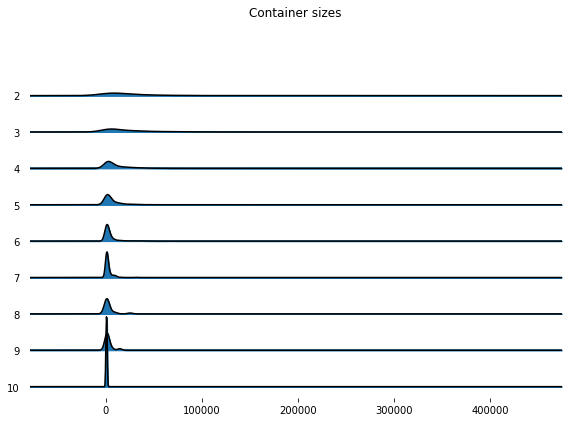

In [20]:
import joypy

fig, axes = joypy.joyplot(dtu, by="n_scales", column="l_2", figsize=(8,6),
                          title="Container sizes", kind = 'kde')

Implementing a couple of function to remove "outliers"

In [21]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 2)
    upper_limit = s.mean() + (s.std() * 2)
    return ~s.between(lower_limit, upper_limit)

def is_windsor_outlier(s):
    lower_limit, upper_limit = s.quantile([0.05, 0.5])
    return ~s.le(upper_limit) 

def iqr_50(s):
    lower_limit, upper_limit = s.quantile([0.25, 0.75])
    return ~s.between(lower_limit, upper_limit)


Descriptive statistics for urban data, we group by the number of scales each individual hasas this influences their container sizes.

In [41]:
urban = dtu[(dtu.urban_rural == 'urban')] # (~dtu.n_scales.isin([2,3])
urban['log_l_2'] = urban['l_2'].apply(lambda x: np.log(x))
urban_f = urban[~urban.groupby('n_scales')['l_2'].apply(is_windsor_outlier)]
urban.groupby('n_scales').describe()

<ipython-input-41-cf53a48aa197>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urban['log_l_2'] = urban['l_2'].apply(lambda x: np.log(x))


l_2                                                       \
          count          mean           std         min          25%   
n_scales                                                               
2          85.0  20808.982422  40165.632812  285.961792  1641.708130   
3         196.0  19236.472656  28119.685547  167.468597  1984.380585   
4         333.0   7074.258789  12125.222656  114.939392  1353.101807   
5         308.0   3548.379150   5604.324707  118.149559   836.235992   
6         163.0   2493.191406   3910.923828   78.769814   753.870483   
7          78.0   2419.917480   4149.819336  230.631470   812.426376   
8          27.0   2923.575439   5219.541504  116.235931   781.593018   
9           5.0   2038.586670   2736.440186  373.983887   402.457520   

                                                   log_l_2            \
                  50%           75%            max   count      mean   
n_scales                                                               
2         4760.777832  24782.695312  247046.750000    85.0  8.706700   
3         6508.369385  26728.415527  194216.171875   196.0  8.858094   
4         2957.205322   6963.916504  119254.312500   333.0  8.050888   
5         1671.262573   3444.182983   43574.613281   308.0  7.476005   
6         1351.120972   2914.073853   36048.093750   163.0  7.250277   
7         1213.295593   2104.252014   31743.029297    78.0  7.231324   
8         1010.828308   1938.150024   25634.437500    27.0  7.197844   
9          574.482849   2074.819580    6767.189941     5.0  6.946549   

                                                                        
               std       min       25%       50%        75%        max  
n_scales                                                                
2         1.594794  5.655858  7.403493  8.468166  10.117901  12.417333  
3         1.548881  5.120796  7.592938  8.779698  10.193449  12.176727  
4         1.260397  4.744405  7.210155  7.992000   8.848497  11.689014  
5         1.147048  4.771951  6.728911  7.421333   8.144405  10.682230  
6         1.052825  4.366530  6.625218  7.208690   7.977307  10.492609  
7         0.927968  5.440821  6.699985  7.100850   7.651682  10.365428  
8         1.177978  4.755622  6.658388  6.918525   7.566263  10.151692  
9         1.253421  5.924213  5.997590  6.353470   7.637629   8.819841

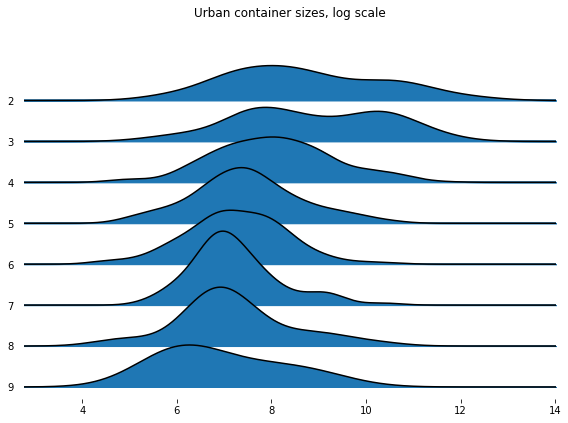

In [57]:
fig, axes = joypy.joyplot(urban, by="n_scales", column="log_l_2", figsize=(8,6),
                          title="Urban container sizes, log scale")

The first thing to notice is that even though these container sizes should represent an area in which each location within the area is considered close. However the mean of each container is more than 2 km with an even larger standard deviation. On the log scale the data might make a bit more sense, however it is immediately apparent that we cannot use container sizes as a measure of what is a good distance to public transport especially when considering accesibility by foot.

What we might try to do is to see if we can determine a scaling factor between the rural and urban sizes which we can use for our accesibility calculations. First we try fitting a Z-score standardizer to the urban container sizes and then transform the rural scales using the urban standardizer. This might give us a better sense of much larger rural containers are than urban. One limitation though is that the rural population has more levels than the urban though this only affects 3 individuals here.

In [43]:
urban_scales = {}
for i, scale in urban.groupby("n_scales"):
    urban_scales[i] = StandardScaler().fit(X = scale[['log_l_2','l_2']])
#urban[['log_l_2_s','l_2_s']] = urban_scale.transform(urban[['log_l_2','l_2']])

2
3
4
5
6
7
8
9


In [46]:
rural = dtu[(dtu.urban_rural == 'rural')] # & (~dtu.n_scales.isin([2,3]))
rural['log_l_2'] = rural['l_2'].apply(lambda x: np.log(x))
rural_f = rural[~rural.groupby('n_scales')['l_2'].apply(is_windsor_outlier)]
rural.groupby('n_scales').describe()

<ipython-input-46-52f62cfa2c1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rural['log_l_2'] = rural['l_2'].apply(lambda x: np.log(x))


l_2                                                       \
          count          mean           std         min          25%   
n_scales                                                               
2         235.0  26728.263672  38344.738281  118.836937  5484.221680   
3         256.0  26411.269531  30581.310547  111.690071  5894.274170   
4         404.0  13780.041992  17324.103516   60.698612  2106.252258   
5         310.0   9151.636719  15186.233398   61.800449  1431.159851   
6         196.0   5076.558594   8406.495117   46.262280   852.826675   
7          73.0   2860.722656   3154.557861   66.295006   759.039490   
8          15.0   3416.193115   6378.398926   75.986732   709.781891   
9           9.0   3118.790039   4385.602051  259.623169  1179.008911   
10          3.0    836.065125    548.749756  256.207367   580.477417   

                                                    log_l_2            \
                   50%           75%            max   count      mean   
n_scales                                                                
2         15145.080078  35829.388672  395233.250000   235.0  9.468736   
3         16719.749023  36378.845703  211276.718750   256.0  9.467634   
4          7692.970215  19747.316895  121446.835938   404.0  8.698164   
5          4375.876465  11696.931885  155263.265625   310.0  8.273407   
6          1786.473694   5324.522095   66657.812500   196.0  7.631231   
7          1907.544189   3736.429688   15874.712891    73.0  7.429696   
8          1593.134033   2228.474976   25047.648438    15.0  7.167216   
9          2356.234863   2407.164062   14536.768555     9.0  7.418910   
10          904.747498   1125.993988    1347.240479     3.0  6.519819   

                                                                        
               std       min       25%       50%        75%        max  
n_scales                                                                
2         1.343087  4.777752  8.609628  9.625431  10.486505  12.887231  
3         1.407756  4.715728  8.681712  9.724323  10.501743  12.260924  
4         1.507800  4.105921  7.652658  8.948058   9.890773  11.707232  
5         1.415530  4.123911  7.266237  8.383858   9.367081  11.952877  
6         1.375965  3.834327  6.748541  7.487304   8.579781  11.107328  
7         1.084107  4.194115  6.632054  7.553572   8.225886   9.672483  
8         1.438735  4.330559  6.559091  7.373458   7.708493  10.128535  
9         1.199564  5.559231  7.072429  7.764820   7.786205   9.584436  
10        0.866541  5.545987  6.176822  6.807656   7.006735   7.205814

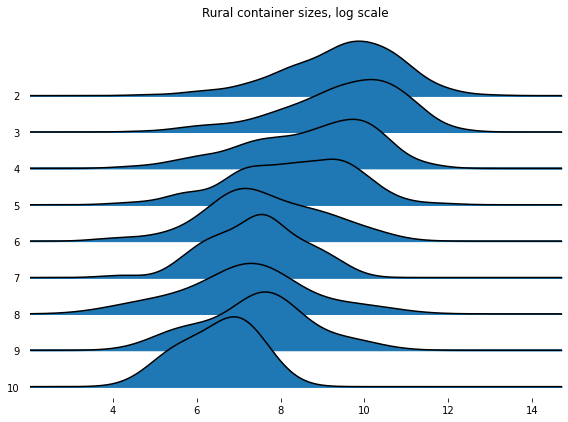

In [47]:
fig, axes = joypy.joyplot(rural, by="n_scales", column="log_l_2", figsize=(8,6),
                          title="Rural container sizes, log scale")

In [48]:
rural_resc = pd.DataFrame()
for i, scale in rural.groupby('n_scales'):
    try:
        scale[['log_l_2_s','l_2_s']] = urban_scales[i].transform(scale[['log_l_2','l_2']])
        rural_resc = rural_resc.append(scale)
    except:
        rural_resc = rural_resc.append(scale)



rural_res = rural_resc[['log_l_2_s','l_2_s', 'n_scales']].groupby('n_scales').describe()
rural_res

<ipython-input-48-5e12fd3726f6>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rural_resc = rural_resc.append(scale)
<ipython-input-48-5e12fd3726f6>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rural_resc = rural_resc.append(scale)
<ipython-input-48-5e12fd3726f6>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rural_resc = rural_resc.append(scale)
<ipython-input-48-5e12fd3726f6>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rural_resc = rural_resc.append(scale)
<ipython-input-48-5e12fd3726f6>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


log_l_2_s                                                    \
             count      mean       std       min       25%       50%   
n_scales                                                               
2            235.0  0.480663  0.847168 -2.478229 -0.061229  0.579500   
3            256.0  0.394544  0.911214 -2.681274 -0.114168  0.560694   
4            404.0  0.514323  1.198090 -3.134651 -0.316432  0.712887   
5            310.0  0.696309  1.236072 -2.927123 -0.183174  0.792757   
6            196.0  0.362954  1.310954 -3.254556 -0.478031  0.225828   
7             73.0  0.215154  1.175820 -3.294151 -0.649967  0.349509   
8             15.0 -0.026496  1.244626 -2.480442 -0.552575  0.151921   
9              9.0  0.421340  1.069995 -1.237468  0.112284  0.729887   
10             0.0       NaN       NaN       NaN       NaN       NaN   

                              l_2_s                                          \
               75%       max  count      mean       std       min       25%   
n_scales                                                                      
2         1.122632  2.636918  235.0  0.148246  0.960331 -0.518178 -0.383803   
3         1.063902  2.202587  256.0  0.255805  1.090326 -0.681862 -0.475694   
4         1.461964  2.905313  404.0  0.553876  1.430916 -0.579298 -0.410342   
5         1.651329  3.909304  310.0  1.001437  2.714144 -0.623135 -0.378398   
6         1.266689  3.674815  196.0  0.662587  2.156115 -0.627593 -0.420724   
7         1.078700  2.647676   73.0  0.106910  0.765088 -0.570834 -0.402819   
8         0.441754  2.535293   15.0  0.096177  1.245302 -0.555956 -0.432215   
9         0.748962  2.352960    9.0  0.441341  1.791836 -0.726835 -0.351200   
10             NaN       NaN    0.0       NaN       NaN       NaN       NaN   

                                         
               50%       75%        max  
n_scales                                 
2        -0.141851  0.376181   9.377330  
3        -0.089730  0.611183   6.846877  
4         0.051104  1.046754   9.446812  
5         0.147894  1.456342  27.115091  
6        -0.181260  0.726185  16.457072  
7        -0.124268  0.319299   3.263246  
8        -0.259752 -0.135710   4.319445  
9         0.129782  0.150591   5.106412  
10             NaN       NaN        NaN

In [56]:
(rural_res.reset_index()['log_l_2_s']['mean'] * rural_res.reset_index()['log_l_2_s']['count'] / rural_res.reset_index()['log_l_2_s']['count'].sum()).sum()

0.4858752949721056

In [ ]:

gmm = GaussianMixture(
            n_components=2, covariance_type='full', random_state=0
        )
gmm.fit(np.expand_dims(urban_f['l_2'], 1))
Gaussian_nr = 1
print(f"Results for all scales")
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print(f'Normal_distb {Gaussian_nr}: μ = {mu}, σ = {sd}, weight = {p}')
    Gaussian_nr += 1 

for scale, scales_group in urban_f.groupby('n_scales'):
    gmm = GaussianMixture(
            n_components=2, covariance_type='full', random_state=0
        )
    gmm.fit(np.expand_dims(scales_group['l_2'], 1))
    Gaussian_nr = 1
    print(f"Results for {scale} scales")
    for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
        print(f'Normal_distb {Gaussian_nr}: μ = {mu}, σ = {sd}, weight = {p}')
        Gaussian_nr += 1 

Results for all scales
Normal_distb 1: μ = 1820.0507839679703, σ = 644.3660541867748, weight = 0.23976555481429998
Normal_distb 2: μ = 774.7001858478501, σ = 378.03525974034795, weight = 0.7602344451857004
Results for 4 scales
Normal_distb 1: μ = 982.5566443180794, σ = 469.7243105090847, weight = 0.6846248540816989
Normal_distb 2: μ = 2359.6063223563747, σ = 386.99013261703396, weight = 0.3153751459183011
Results for 5 scales
Normal_distb 1: μ = 1244.3546794350063, σ = 258.1796688150506, weight = 0.4629034714705327
Normal_distb 2: μ = 537.9963357986411, σ = 263.63099432578855, weight = 0.5370965285294669
Results for 6 scales
Normal_distb 1: μ = 397.31796301388675, σ = 185.81095835737955, weight = 0.4270586656062598
Normal_distb 2: μ = 983.6666423092522, σ = 222.95212262230197, weight = 0.5729413343937403
Results for 7 scales
Normal_distb 1: μ = 886.090447485434, σ = 147.63617960936608, weight = 0.7223126757011814
Normal_distb 2: μ = 411.8467824512353, σ = 104.97914804747349, weight = 0

In [ ]:
gmm = GaussianMixture(
            n_components=2, covariance_type='full', random_state=0
        )
gmm.fit(np.expand_dims(rural_f['l_2'], 1))
Gaussian_nr = 1
print(f"Results for all scales")
for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    print(f'Normal_distb {Gaussian_nr}: μ = {mu}, σ = {sd}, weight = {p}')
    Gaussian_nr += 1 

for scale, scales_group in rural_f.groupby('n_scales'):
    gmm = GaussianMixture(
            n_components=2, covariance_type='full', random_state=0
        )
    gmm.fit(np.expand_dims(scales_group['l_2'], 1))
    Gaussian_nr = 1
    print(f"Results for {scale} scales")
    for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
        print(f'Normal_distb {Gaussian_nr}: μ = {mu}, σ = {sd}, weight = {p}')
        Gaussian_nr += 1 

Results for all scales
Normal_distb 1: μ = 952.3431119625265, σ = 573.8798901886895, weight = 0.6704169489447778
Normal_distb 2: μ = 3745.010161357956, σ = 1802.19363960046, weight = 0.32958305105522323
Results for 4 scales
Normal_distb 1: μ = 1498.3224322264127, σ = 1028.1687543941089, weight = 0.6957837016904492
Normal_distb 2: μ = 5588.81957582411, σ = 1332.2303333006141, weight = 0.3042162983095508
Results for 5 scales
Normal_distb 1: μ = 1024.4034313564528, σ = 586.8182772626286, weight = 0.6756657563066303
Normal_distb 2: μ = 3132.2774969770617, σ = 692.6239393642834, weight = 0.32433424369337
Results for 6 scales
Normal_distb 1: μ = 1305.3727182232562, σ = 237.77773883002803, weight = 0.41054028722492525
Normal_distb 2: μ = 555.2410755015303, σ = 289.6942281892063, weight = 0.5894597127750746
Results for 7 scales
Normal_distb 1: μ = 1485.2295203538247, σ = 304.9907349108146, weight = 0.37060459365309717
Normal_distb 2: μ = 557.6271714368144, σ = 242.45892850227594, weight = 0.62